# Импорт необходимых библиотек

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.8 MB/s eta 0:00:00


In [6]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

# Загрузка набора данных

Набор данных представляет собой датасет, полученный с популярнеого онлайн авто маркетплейса.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип топлива.


In [8]:
DF = pd.read_csv('/content/cars_raw.csv', delimiter = ',')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   9379 non-null   int64  
 1   Make                   9379 non-null   object 
 2   Model                  9379 non-null   object 
 3   Used/New               9379 non-null   object 
 4   Price                  9379 non-null   object 
 5   ConsumerRating         9379 non-null   float64
 6   ConsumerReviews        9379 non-null   int64  
 7   SellerType             9379 non-null   object 
 8   SellerName             9379 non-null   object 
 9   SellerRating           9379 non-null   float64
 10  SellerReviews          9379 non-null   int64  
 11  StreetName             9379 non-null   object 
 12  State                  9379 non-null   object 
 13  Zipcode                9379 non-null   object 
 14  DealType               9157 non-null   object 
 15  Comf

In [39]:
df_new = DF[['Year', 'Make', 'Model', 'Used/New', 'SellerRating', 'FuelType', 'Transmission', 'Mileage', 'Price']].copy()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          9379 non-null   int64  
 1   Make          9379 non-null   object 
 2   Model         9379 non-null   object 
 3   Used/New      9379 non-null   object 
 4   SellerRating  9379 non-null   float64
 5   FuelType      9379 non-null   object 
 6   Transmission  9379 non-null   object 
 7   Mileage       9379 non-null   int64  
 8   Price         9379 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 659.6+ KB


In [40]:
df_new['Price'] = df_new['Price'].str.replace('$', '')
df_new['Price'] = df_new['Price'].str.replace('Not Priced', '0')
df_new['Price'] = df_new['Price'].str.replace(',', '').astype(int)

In [41]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          9379 non-null   int64  
 1   Make          9379 non-null   object 
 2   Model         9379 non-null   object 
 3   Used/New      9379 non-null   object 
 4   SellerRating  9379 non-null   float64
 5   FuelType      9379 non-null   object 
 6   Transmission  9379 non-null   object 
 7   Mileage       9379 non-null   int64  
 8   Price         9379 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 659.6+ KB


Список числовых и категориальных данных

In [42]:
cat_columns = []
num_columns = []

for column_name in df_new.columns:
    if (df_new[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))



categorical columns:	  ['Make', 'Model', 'Used/New', 'FuelType', 'Transmission'] 
 len =  5
numerical columns:	  ['Year', 'SellerRating', 'Mileage', 'Price'] 
 len =  4


In [56]:
# не забываем удалить целевую переменную цену из признаков
X, y = df_new.drop(columns = ['Price']), df_new['Price']
features_names = list(df_new.drop(columns = ["Price"]).columns)

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

## Модель CatBoost


In [30]:
from catboost import Pool

In [31]:
from catboost import CatBoostRegressor

In [57]:
train_data_reg = Pool(
    data=X_train,
    label=y_train,
    cat_features = cat_columns,
    feature_names=features_names,
)

eval_data_reg = Pool(
    data=X_val,
    label=y_val,
    cat_features = cat_columns,
    feature_names=features_names
)

Создаем Класс, как обычно

Ключевые настройки:

* `iterations` - количество деревьев / итераций обучения

* `objective`- функция потерь, которую надо минимизировать при обучении. Есть показатели для регрессии (среднеквадратичная ошибка), есть для классификации (`logloss`).
* `eval_metric` - валидационная метрика, используемая для обнаружения переобучения и ранней остановки;
* `early_stopping_rounds` - число итераций до остановки, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной;
* `cat_features` - список категориальных признаков (чтобы модель сделала свой TargetEncoder внутри)
* `depth` - глубина дерева  (по умолчанию 6, максимальное значение - 16)
* `verbose` - объем выводимой информации (выдавливать ответ каждые n итераций)
* `random_state` – фиксируем сид для воспроизводимости;

In [60]:
model_reg = CatBoostRegressor(iterations = 10000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                              objective  = 'MAE',
                           eval_metric= 'MAE',
                              random_state = 42
                           )


In [61]:
model_reg.fit(X=train_data_reg,
              eval_set=eval_data_reg,)

0:	learn: 11978.5743740	test: 12147.3042881	best: 12147.3042881 (0)	total: 6.57ms	remaining: 1m 5s
100:	learn: 7123.6013150	test: 6890.1308154	best: 6890.1308154 (100)	total: 428ms	remaining: 41.9s
200:	learn: 6624.4656086	test: 6404.0337222	best: 6404.0337222 (200)	total: 905ms	remaining: 44.1s
300:	learn: 6449.7422649	test: 6253.4753100	best: 6253.4753100 (300)	total: 1.39s	remaining: 44.6s
400:	learn: 6269.6696657	test: 6106.4800201	best: 6106.4800201 (400)	total: 1.8s	remaining: 43.1s
500:	learn: 6136.3210775	test: 5994.9579571	best: 5994.9579571 (500)	total: 2.21s	remaining: 41.9s
600:	learn: 6037.0486014	test: 5918.1527079	best: 5918.1527079 (600)	total: 2.64s	remaining: 41.4s
700:	learn: 5949.0199572	test: 5855.3019668	best: 5855.1610395 (699)	total: 3.06s	remaining: 40.6s
800:	learn: 5878.9826013	test: 5803.4714300	best: 5803.4714300 (800)	total: 3.48s	remaining: 40s
900:	learn: 5817.6924996	test: 5757.1753576	best: 5757.1753576 (900)	total: 3.91s	remaining: 39.5s
1000:	learn: 

## Глубина дерева для Отрисовки

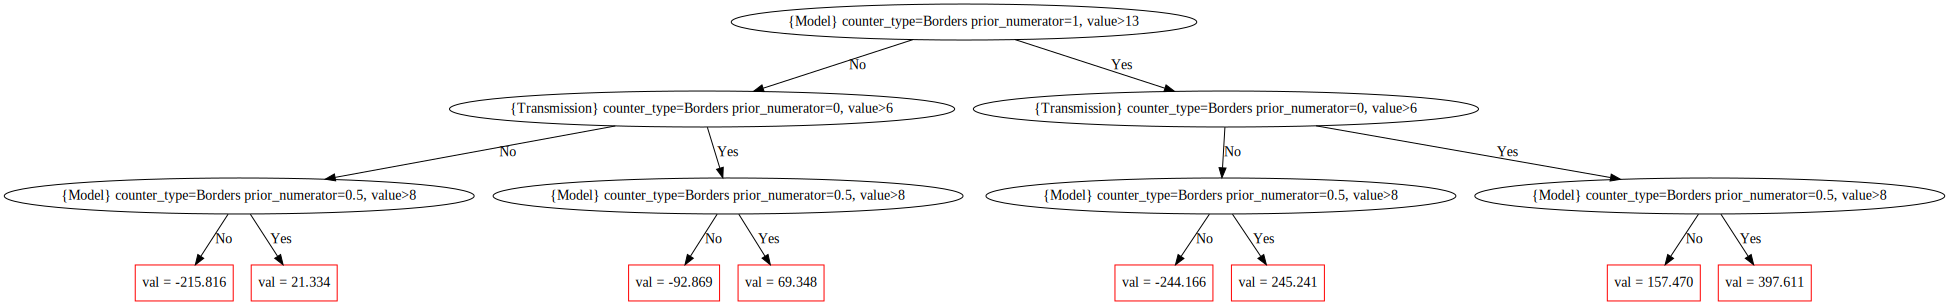

In [62]:
#@title Глубина дерева для Отрисовки{ run: "auto" }
tree_idx=5 #@param {type:"slider", min:0, max:25, step:1}

model_reg.plot_tree(tree_idx=tree_idx,
                pool = train_data_reg)

In [63]:
results = model_reg.evals_result_

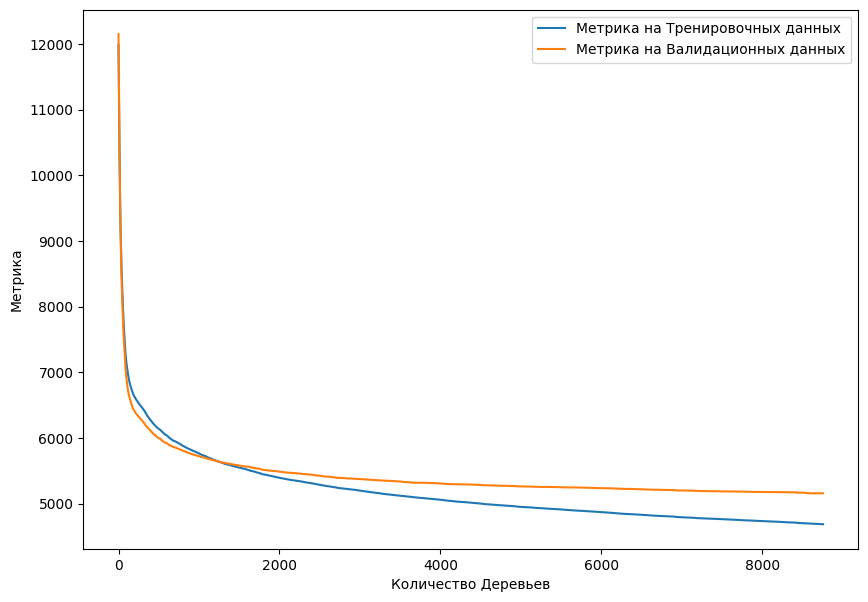

In [64]:
plt.figure(figsize=(10,7))
plt.plot(results["learn"]["MAE"], label="Метрика на Тренировочных данных")
plt.plot(results["validation"]["MAE"], label="Метрика на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрика")
plt.legend();

## Визуализация значимости признаков

In [65]:
def feature_importance_plotter(model, features_names):
    """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
    Параметры:
    ===========
    model: модель
    features_names: список имен признаков
    """
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    #plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

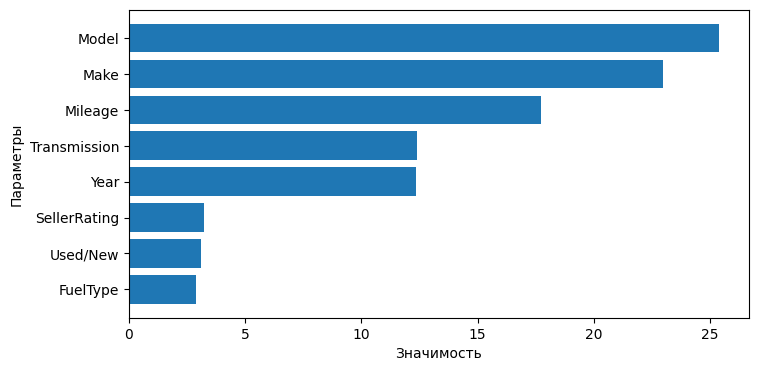

In [66]:
feature_importance_plotter(model_reg, np.array(features_names))

## Оценка метрик

In [67]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [68]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_reg, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_reg, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_reg, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_reg, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.5998
r2 на валидационной выборке: 0.5470
mse на тренировочной выборке: 170925719.1020
mse на валидационной выборке: 202360333.9219


## Кросс-валидация

In [69]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [70]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [71]:
cross_validation (X_train, y_train,
                  model_reg,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

0:	learn: 11981.6486193	total: 21.3ms	remaining: 3m 33s
100:	learn: 7131.8210949	total: 1.21s	remaining: 1m 58s
200:	learn: 6653.1869008	total: 1.82s	remaining: 1m 28s
300:	learn: 6501.7727066	total: 2.63s	remaining: 1m 24s
400:	learn: 6340.0058237	total: 3.46s	remaining: 1m 22s
500:	learn: 6205.9482063	total: 4.24s	remaining: 1m 20s
600:	learn: 6109.6583772	total: 5.04s	remaining: 1m 18s
700:	learn: 6028.9500149	total: 5.71s	remaining: 1m 15s
800:	learn: 5967.0714828	total: 6.08s	remaining: 1m 9s
900:	learn: 5903.3552258	total: 6.46s	remaining: 1m 5s
1000:	learn: 5854.8742732	total: 6.83s	remaining: 1m 1s
1100:	learn: 5808.5333562	total: 7.2s	remaining: 58.2s
1200:	learn: 5768.6814034	total: 7.59s	remaining: 55.6s
1300:	learn: 5727.1458113	total: 7.98s	remaining: 53.4s
1400:	learn: 5695.1643138	total: 8.38s	remaining: 51.4s
1500:	learn: 5660.9922254	total: 8.76s	remaining: 49.6s
1600:	learn: 5634.5006331	total: 9.14s	remaining: 47.9s
1700:	learn: 5603.0988564	total: 9.54s	remaining: 4

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,58.764939,0.040927,0.630852,-1.485766e+08,-4640.632196,-189366.331402
1,49.273407,0.019664,0.768181,-5.516940e+07,-4173.210835,-71784.040590
2,50.588349,0.025703,0.591039,-1.501990e+08,-4544.298905,-206673.124931
3,51.250103,0.038387,0.677301,-1.070683e+08,-4712.692411,-163376.146355
4,52.069187,0.018939,0.501458,-2.708209e+08,-5565.633277,-226601.307387




test_R2      6.337663e-01
test_-MSE   -1.463669e+08
test_-MAE   -4.727294e+03
test_-Max   -1.715602e+05
dtype: float64


## Визуализация ошибок от scikit-learn

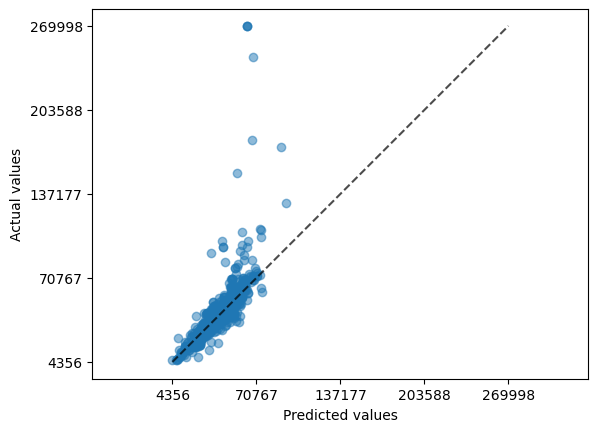

In [72]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg.predict(eval_data_reg),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы

* Модель регрессии от CatBoost показало лучше результат, чем К ближайших соседей на этой выборке

* Анализ значимости признаков говорит о том, что CatBoost в данном примере предпочитает категориальные признакми, в отличие от учебного примера.

## Полезность объектов

In [73]:
# метод возвращает отсортированные списки индексов и скоров
idxs, scores = model_reg.get_object_importance(
    train_data_reg, eval_data_reg ,
    importance_values_sign="Positive"
)
len(idxs)

826

In [78]:
# Попробуем отбросить половину найденных и посмотрим как изменится точность
train_pool = Pool(
    X_train.reset_index(drop=True).drop(idxs[:400]),
    y_train.reset_index(drop=True).drop(idxs[:400]),
    cat_features=cat_columns,
)

model_clean =  CatBoostRegressor(iterations = 10000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                              objective  = 'MAE',
                           eval_metric= 'MAE',
                              random_state = 42
                           )

model_clean.fit(
    train_pool,
    eval_set=eval_data_reg,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

0:	learn: 11989.0066838	test: 12140.5811788	best: 12140.5811788 (0)	total: 5.95ms	remaining: 59.5s
100:	learn: 7193.6627567	test: 6953.4978771	best: 6953.4978771 (100)	total: 494ms	remaining: 48.4s
200:	learn: 6687.0672236	test: 6474.5075532	best: 6474.5075532 (200)	total: 1.48s	remaining: 1m 12s
300:	learn: 6533.5367397	test: 6344.9425593	best: 6344.9425593 (300)	total: 2.37s	remaining: 1m 16s
400:	learn: 6361.7964520	test: 6203.0735316	best: 6203.0735316 (400)	total: 3.35s	remaining: 1m 20s
500:	learn: 6209.0842853	test: 6076.5214077	best: 6076.5214077 (500)	total: 4.3s	remaining: 1m 21s
600:	learn: 6097.9744980	test: 5992.3118024	best: 5992.3118024 (600)	total: 4.68s	remaining: 1m 13s
700:	learn: 6007.2246127	test: 5922.9338904	best: 5922.9338904 (700)	total: 5.09s	remaining: 1m 7s
800:	learn: 5926.3179722	test: 5855.1397684	best: 5855.1397684 (800)	total: 5.49s	remaining: 1m 3s
900:	learn: 5857.4143348	test: 5806.8590678	best: 5806.5974888 (898)	total: 5.91s	remaining: 59.6s
1000:	

In [79]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_clean, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_clean, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_clean, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_clean, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.5804
r2 на валидационной выборке: 0.5159
mse на тренировочной выборке: 179193384.3230
mse на валидационной выборке: 216264962.1097


r2 0,54 против 0,51 на валидационной выборке

## Оптимизация гиперпараметров

In [80]:
from scipy import stats

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_columns,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train, y_train)
model.best_score_

0:	learn: 43415.9265114	test: 45023.1386969	best: 45023.1386969 (0)	total: 5.99ms	remaining: 5.98s
500:	learn: 14870.2744137	test: 17702.7389626	best: 17702.7389626 (500)	total: 1.05s	remaining: 1.04s
999:	learn: 14640.3976441	test: 17480.4924102	best: 17480.0455734 (996)	total: 3.8s	remaining: 0us

bestTest = 17480.04557
bestIteration = 996

0:	loss: 17480.0455734	best: 17480.0455734 (0)	total: 3.87s	remaining: 34.8s
0:	learn: 43415.9265114	test: 45023.1386969	best: 45023.1386969 (0)	total: 19.8ms	remaining: 19.8s
500:	learn: 14870.2744137	test: 17702.7389626	best: 17702.7389626 (500)	total: 2.02s	remaining: 2.01s
999:	learn: 14640.3976441	test: 17480.4924102	best: 17480.0455734 (996)	total: 3.34s	remaining: 0us

bestTest = 17480.04557
bestIteration = 996

1:	loss: 17480.0455734	best: 17480.0455734 (0)	total: 7.25s	remaining: 29s
0:	learn: 43415.9265114	test: 45023.1386969	best: 45023.1386969 (0)	total: 3.14ms	remaining: 3.14s
500:	learn: 14870.2744137	test: 17702.7389626	best: 17702.

{'learn': {'RMSE': 7896.203987655419}}

In [81]:
# Лучшие параметры модели из перебора
randomized_search_result["params"]

{'depth': 4, 'one_hot_max_size': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 2}

In [82]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8462
r2 на валидационной выборке: 0.6820
mse на тренировочной выборке: 65667702.7176
mse на валидационной выборке: 142071076.6451


Оптимизация гиперпараметров улучшила метрик с 0,54 до 0,68 на валидационной выборке.

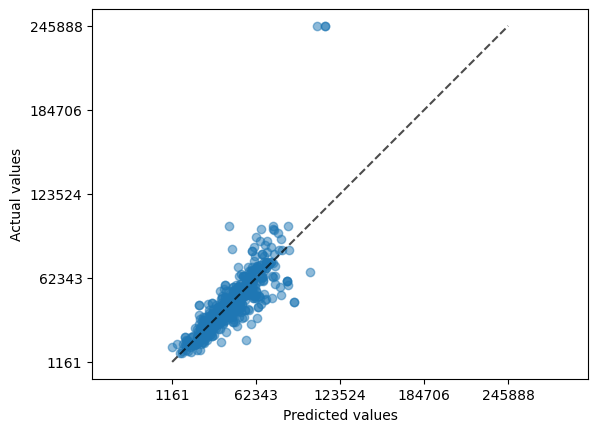

In [83]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(eval_data_reg),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

In [84]:
# сохранение модели
model.save_model("catboost_model.cbm", format="cbm")  # есть свой формат данных